In [1]:
import sys
sys.path.append("/Users/cosinga/code/figrid/")
sys.path.append("/Users/cosinga/code/sparta_dev/analysis/")

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'serif'
import matplotlib.cm as cm
from sparta_tools import moria, sparta
import h5py as hp
import plotly.graph_objects as go
import numpy as np
import numpy.linalg as la

BASE = '/Users/cosinga/sims/sparta_output/'
SAVE = '/Users/cosinga/overleaf/proposal_defense/figures/'
sdata = sparta.load(BASE + "sparta_cbol_l0063_n0256_strd1_calvin.hdf5", load_halo_data = True, 
                    anl_match = ['hps', 'rsp'], anl_pad_unmatched = True,
                   res_match = ['ifl', 'oct', 'tjy'], res_pad_unmatched = True)


sparta.load: Loading file /Users/cosinga/sims/sparta_output/sparta_cbol_l0063_n0256_strd1_calvin.hdf5.
sparta.load: Loading 19226/19226 halos from SPARTA file (entire array)...
sparta.load: Matching result IDs in tracer sho, halo 1923/19226
sparta.load: Matching result IDs in tracer sho, halo 3845/19226
sparta.load: Matching result IDs in tracer sho, halo 5767/19226
sparta.load: Matching result IDs in tracer sho, halo 7689/19226
sparta.load: Matching result IDs in tracer sho, halo 9611/19226
sparta.load: Matching result IDs in tracer sho, halo 11533/19226
sparta.load: Matching result IDs in tracer sho, halo 13455/19226
sparta.load: Matching result IDs in tracer sho, halo 15377/19226
sparta.load: Matching result IDs in tracer sho, halo 17299/19226
sparta.load: Matching result IDs in tracer sho, halo 19221/19226


In [2]:
sho = sdata['tcr_sho']
tjy = sho['res_tjy']
oct = sho['res_oct']
ifl = sho['res_ifl']
print(ifl.dtype.names)
print(tjy.dtype.names)
print(oct.dtype.names)
hdata = sdata['halos']
print(hdata.dtype.names)

('born_in_halo', 'sub_mass_ratio', 't_infall', 'tracer_id', 'vrv200', 'vtv200', 'x')
('first_snap', 'last_snap', 'r', 'tracer_id', 'v', 'vr', 'vt', 'x')
('last_pericenter_snap', 'n_is_lower_limit', 'n_pericenter', 'tracer_id')
('R200m', 'first_snap', 'id', 'last_snap', 'parent_id', 'position', 'status', 'status_final', 'velocity', 'anl_hps_first', 'anl_hps_n', 'anl_rsp_first', 'anl_rsp_n', 'sho_ifl_first', 'sho_ifl_n', 'sho_oct_first', 'sho_oct_n', 'sho_tjy_first', 'sho_tjy_n')


# Projecting Positions

Project trajectories in $\vec{L_i}$ plane. This is done by 

In [3]:
# first let's get the unit vectors of new plane
# get positions

pos = tjy['x'].copy()
rad = tjy['r'].copy()
vel = tjy['v'].copy()


# initialize array for projected positions
# -1 for snaps where tracer was not alive
proj_pos = np.ones_like(pos) * -1

# if all positions are -1, then subhalo tracer does not exist at that snapshot
alive = ~(np.all(pos == -1, axis = 2))

    
# get rhat
rhat = np.zeros_like(pos)
rhat[alive, :] = pos[alive, :] / rad[alive, np.newaxis]

    
# get Lhat, initial vel x initial pos
lhat = np.zeros_like(pos)
ang_mom = np.cross(pos[alive, :], vel[alive, :])
lhat[alive, :] = ang_mom / la.norm(ang_mom, axis = 1)[:, np.newaxis]

# get theta_hat, cross product of other two unit vectors
that = np.zeros_like(pos)
cross_prod = np.cross(rhat[alive, :], lhat[alive, :])
that[alive, :] = cross_prod / la.norm(cross_prod, axis = 1)[:, np.newaxis]

    
# get mask of first snaps each tracer was alive
ini_mask = np.zeros_like(alive, dtype = bool)
ini_idxs = np.argmax(alive, axis = 1)
ini_mask[np.arange(ini_mask.shape[0]), ini_idxs] = True

# 3 x 3 transformation matrix for each particle
trans_matrix = np.array([rhat[ini_mask], that[ini_mask], lhat[ini_mask]])
trans_matrix = np.swapaxes(trans_matrix, 0, 1)

# rhat, that, lhat define new x,y,z plane at first alive snap
# project pos into that plane with dot products

# perform dot product on all positions, use einsum to do so element-wise
proj_pos_temp = np.einsum('ijk,ilk->ijl', pos, trans_matrix)

# only save the positions where the tracer was actually alive
proj_pos[alive, :] = proj_pos_temp[alive, :]

# force all of the orbits to go CCW.
# I'm taking a simplistic approach, finding the sign of the second
# y-value of the orbit to determine whether the orbit is CW or CCW


# add one to initial index, prevent index error with ceiling
sec_idxs = np.minimum(ini_idxs + 1, alive.shape[1] - 1)
sec_mask = np.zeros_like(alive, dtype = bool)
sec_mask[np.arange(ini_mask.shape[0]), sec_idxs] = True

# check if any were alive for only one snap - if so
# get the y values' sign
ysign = np.sign(proj_pos[sec_mask, 1])

# multiply all yvals by ysign
new_y = proj_pos[:, :, 1] * ysign[:, np.newaxis]
proj_pos[alive, 1] = new_y[alive]

ntcrs = proj_pos.shape[0]

In [4]:
# make array of the R200m values for each tracer
hrad = np.ones_like(alive, dtype = float) * -1 # null val is -1

nhalos = hdata['R200m'].shape[0]
for i in range(nhalos):
    fidx = hdata['sho_tjy_first'][i]
    lidx = fidx + hdata['sho_tjy_n'][i]
    hrad[fidx:lidx, :] = hdata['R200m'][i, :]


In [5]:
def xy(tidx):
    x = proj_pos[tidx, alive[tidx], 0] / hrad[tidx, alive[tidx]]
    y = proj_pos[tidx, alive[tidx], 1] / hrad[tidx, alive[tidx]]
    return x, y

# Comparing Orbits of Various Subsamples


In [6]:
def plot_orb(ax, idx_list, name = '', color = 'blue', lw = 0.05, size = 250):
    rngidx = np.random.choice(len(idx_list), size = size, replace = False)

    for i in rngidx:
        x,y = xy(idx_list[i])
        ax.plot(x, y, color = color, linewidth = lw)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(name)
    frac = size/len(idx_list)
    ax.text(0.95, 0.05, '$f_{\\mathrm{orb}} = %.4f$'%frac,
           ha = 'right', va='bottom', fontsize = 14,
           transform=ax.transAxes)
    return

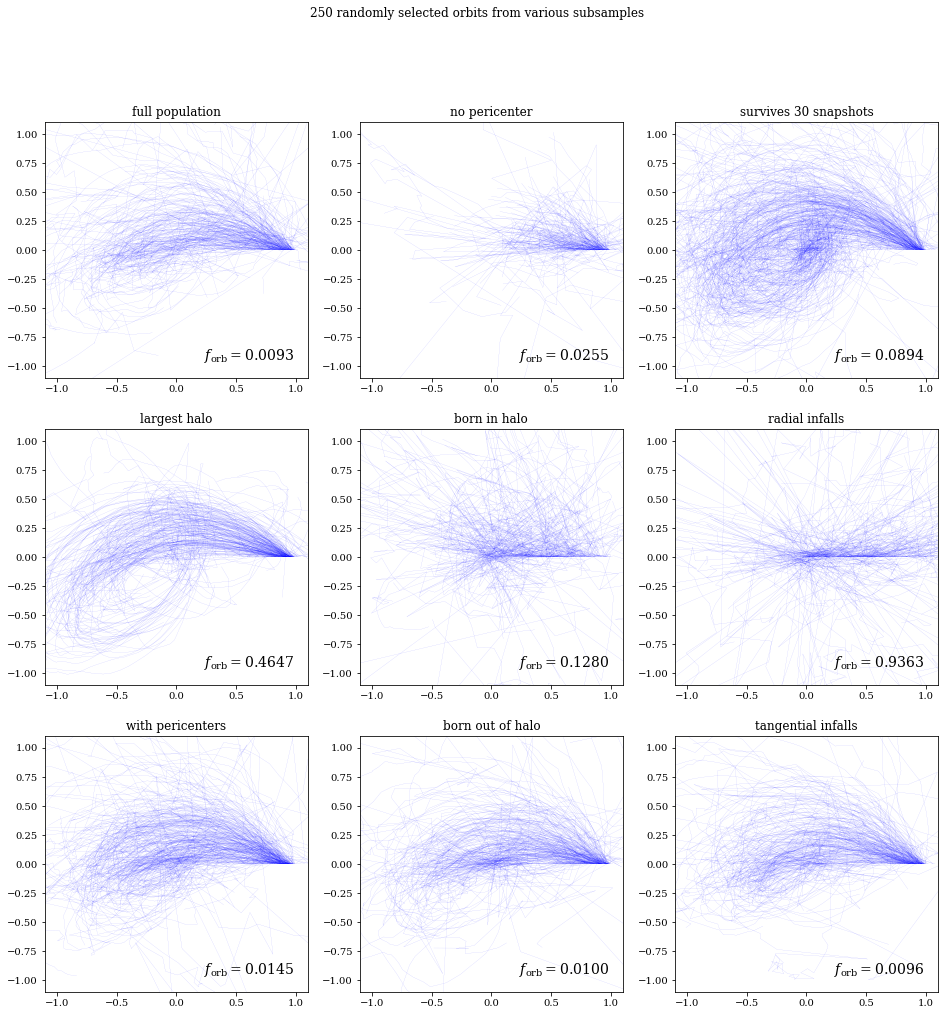

In [7]:
fig, axes = plt.subplots(3,3, figsize = (16,16))
fig.suptitle('250 randomly selected orbits from various subsamples')

# random sample of 250
plot_orb(axes[0,0], np.arange(ntcrs), 'full population')

# sample from largest halo
mx = np.max(hdata['R200m'])
idxs = np.where(hrad == mx)[0]
plot_orb(axes[1, 0], idxs, 'largest halo')

# sample from subhalos with pericenters
has_peri = np.where(oct['n_pericenter'] > 0)[0]
plot_orb(axes[2, 0], has_peri, 'with pericenters')

# sample from those with no pericenters
no_peri = np.where(oct['n_pericenter'] == 0)[0]
plot_orb(axes[0, 1], no_peri, 'no pericenter')

# born in halo
in_halo = np.where(ifl['born_in_halo'] == 1)[0]
plot_orb(axes[1, 1], in_halo, 'born in halo')

# born out halo
out_halo = np.where(ifl['born_in_halo'] == 0)[0]
plot_orb(axes[2, 1], out_halo, 'born out of halo')

# long lived
alive_snap_count = np.sum(alive, axis = 1)
sc_mask = alive_snap_count > 30
long = np.where(sc_mask)[0]
plot_orb(axes[0, 2], long, 'survives 30 snapshots')

# radial infall - defined as 60 degrees?
vr_mask = tjy['vr'][ini_mask] > np.sqrt(3) * tjy['vt'][ini_mask]
plot_orb(axes[1, 2], np.where(vr_mask)[0], 'radial infalls')

# tangential infall
vt_mask = tjy['vt'][ini_mask] > np.sqrt(3) * tjy['vr'][ini_mask]
plot_orb(axes[2, 2], np.where(vt_mask)[0], 'tangential infalls')


In [8]:
def plot_orb_hist(ax, mask, cmap = 'viridis', name = '', text = True, bnum = 30):
    alive_sub = alive[mask,:]
    hrad_sub = hrad[mask]
    ppos = proj_pos.copy()[mask]
    x = np.ravel(ppos[alive_sub, 0] / hrad_sub[alive_sub])
    y = np.ravel(ppos[alive_sub, 1] / hrad_sub[alive_sub])

    bins = np.linspace(-1.1, 1.1, bnum)
    hist, xedges, yedges = np.histogram2d(x, y, bins = [bins, bins])

    data = np.log10(hist)
    # any data below zero, enforce at 0
    data[data < 0] = 0
    ax.imshow(np.flipud(np.rot90(data)), origin = 'lower', extent = (-1.1, 1.1, -1.1, 1.1), cmap = cmap)

    ax.set_title(name)
    frac = np.sum(mask) / ntcrs
    if text:
        ax.text(0.95, 0.05, '$f_{\\mathrm{pop}} = %.4f$'%frac,
               ha = 'right', va='bottom', fontsize = 14, color = 'white',
               transform=ax.transAxes)
    return np.min(data), np.max(data)

/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_30181/476417840.py:11: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(hist)


(0.0, 3.967032882158702)

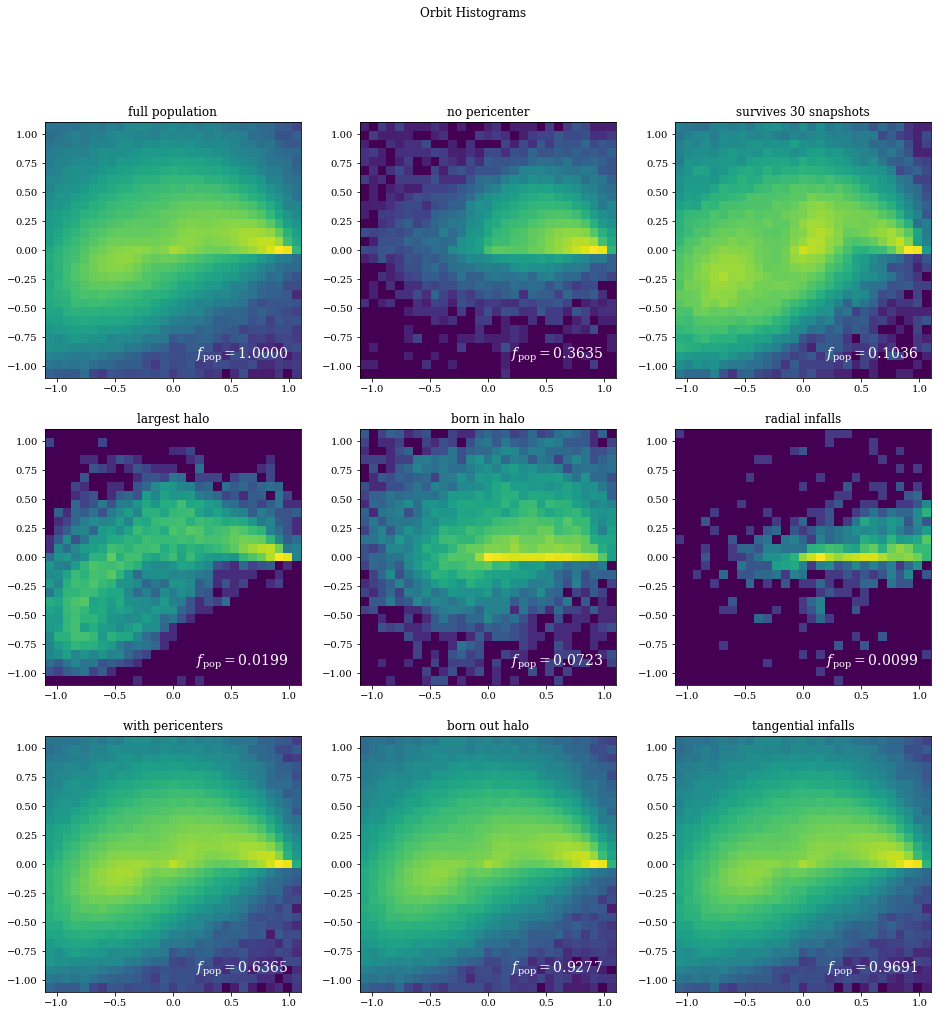

In [9]:
fig, axes = plt.subplots(3,3, figsize = (16,16))
fig.suptitle('Orbit Histograms')

# full population
plot_orb_hist(axes[0,0], np.ones(ntcrs, dtype = bool), name = 'full population')

# sample from largest halo
mx = np.max(hdata['R200m'])
idxs = np.where(hrad == mx)[0]
mask = np.zeros(ntcrs, dtype = bool)
mask[idxs] = True
plot_orb_hist(axes[1, 0], mask, name = 'largest halo')

# sample from subhalos with pericenters
has_peri = oct['n_pericenter'] > 0
plot_orb_hist(axes[2, 0], has_peri, name = 'with pericenters')

# sample from those with no pericenters
plot_orb_hist(axes[0, 1], ~has_peri, name = 'no pericenter')

# born in halo
in_halo = ifl['born_in_halo'] > 0.5
plot_orb_hist(axes[1, 1], in_halo, name = 'born in halo')

# born out halo
plot_orb_hist(axes[2, 1], ~in_halo, name = 'born out halo')

# out_halo = np.where(ifl['born_in_halo'] == 0)[0]
# plot_orb(axes[2, 1], out_halo, 'born out of halo')

# long lived
alive_snap_count = np.sum(alive, axis = 1)
sc_mask = alive_snap_count > 30
plot_orb_hist(axes[0,2], sc_mask, name = 'survives 30 snapshots')


# radial infall - defined as 60 degrees?
vr_mask = tjy['vr'][ini_mask] > np.sqrt(3) * tjy['vt'][ini_mask]
plot_orb_hist(axes[1, 2], vr_mask, name = 'radial infalls')

# tangential infall
vt_mask = tjy['vt'][ini_mask] > np.sqrt(3) * tjy['vr'][ini_mask]
plot_orb_hist(axes[2, 2], vt_mask, name = 'tangential infalls')


# Pericenters

In [10]:
peri_snap = oct['last_pericenter_snap']
peri_pos = np.zeros((ntcrs, 3))
peri_pos[:,:] = proj_pos[np.arange(ntcrs), peri_snap, :]
peri_hrad = hrad[np.arange(ntcrs), peri_snap]

def peri_hist(ax, mask, cmap = 'viridis', name = '', bnum = 30):
    
    
    x = peri_pos[mask, 0] / peri_hrad[mask]
    y = peri_pos[mask, 1] / peri_hrad[mask]

    bins = np.linspace(-1.1, 1.1, bnum)
    hist, xedges, yedges = np.histogram2d(x, y, bins = [bins, bins])

    data = np.log10(hist)
    # any data below zero, enforce at 0
    data[data < 0] = 0
    im = ax.imshow(np.flipud(np.rot90(data)), origin = 'lower', 
                   extent = (-1.1, 1.1, -1.1, 1.1), cmap = cmap)

    ax.set_title(name)
    frac = np.sum(mask) / ntcrs
#     ax.text(0.95, 0.05, '$f_{\\mathrm{pop}} = %.4f$'%frac,
#            ha = 'right', va='bottom', fontsize = 14, color = 'white',
#            transform=ax.transAxes)
    return np.min(data), np.max(data)

/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_30181/1739337324.py:15: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(hist)


Text(0, 0.5, '$y / R_{200m}$')

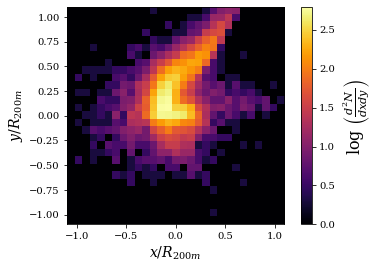

In [11]:
ax = plt.gca()
has_peri = oct['n_pericenter'] > 0

cmap = plt.get_cmap('inferno')

mn, mx = peri_hist(ax, has_peri, cmap)

# Create a normalization object to scale the data to [0, 1] for the colormap
norm = plt.Normalize(vmin=mn, vmax=mx)

# Create a ScalarMappable object using the colormap and normalization
scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable = scalar_mappable)
fig = plt.gcf()
fig.text(0.95, 0.5, 'log $\\left( \\frac{d^2N}{dx dy} \\right)$', rotation = 'vertical', 
         fontsize = 16, ha = 'right', va = 'center')
plt.xlabel('$x / R_{200m}$', fontsize = 14)
plt.ylabel('$y / R_{200m}$', fontsize = 14)

/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_30181/1739337324.py:15: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(hist)


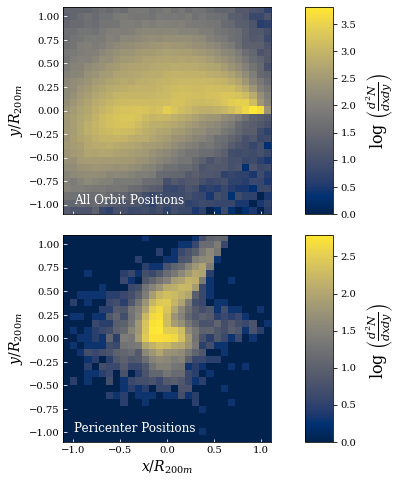

In [12]:
fig, axes = plt.subplots(2, 2, gridspec_kw = dict(width_ratios = [1, 1/8], hspace = 0.1), figsize = (5, 8))
cmap = plt.get_cmap('cividis')

mn, mx = plot_orb_hist(axes[0,0], has_peri, cmap, text = False)
norm = plt.Normalize(vmin=mn, vmax=mx)

scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable = scalar_mappable, cax = axes[0, 1])

mn, mx = peri_hist(axes[1,0], has_peri, cmap)

norm = plt.Normalize(vmin=mn, vmax=mx)

scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable = scalar_mappable, cax = axes[1, 1])
fig.text(1.075, 0.3, 'log $\\left( \\frac{d^2N}{dx dy} \\right)$', rotation = 'vertical', 
         fontsize = 16, ha = 'right', va = 'center')
fig.text(1.075, 0.7, 'log $\\left( \\frac{d^2N}{dx dy} \\right)$', rotation = 'vertical', 
         fontsize = 16, ha = 'right', va = 'center')
axes[0,0].tick_params(direction = 'in', color = 'white', which = 'both', labelbottom = False)
axes[1,0].tick_params(direction = 'in', color = 'white', which = 'both')

axes[0,0].text(0.05, 0.05, 'All Orbit Positions', color = 'white', transform = axes[0,0].transAxes, fontsize = 12)
axes[1, 0].text(0.05, 0.05, 'Pericenter Positions', color = 'white', transform = axes[1, 0].transAxes, fontsize = 12)
axes[1,0].set_xlabel('$x / R_{200m}$', fontsize = 14)
axes[0,0].set_ylabel('$y / R_{200m}$', fontsize = 14)
axes[1,0].set_ylabel('$y / R_{200m}$', fontsize = 14)
fig.savefig(SAVE + 'orbit_hists.png', dpi = 150)

In [13]:
def plot_orb_peri(ax, idx_list, color = 'blue', lw = 0.05, size = 250):
    rngidx = np.random.choice(len(idx_list), size = size, replace = False)
    x = peri_pos[mask, 0] / peri_hrad[mask]
    y = peri_pos[mask, 1] / peri_hrad[mask]
    peris = np.zeros((len(rngidx), 2))
    pi = 0
    for i in rngidx:
        x,y = xy(idx_list[i])
        peris[pi, :] = peri_pos[idx_list[i], :2] / peri_hrad[idx_list[i]]
        pi += 1
        ax.plot(x, y, color = color, linewidth = lw)
    
    ax.scatter(peris[:, 0], peris[:, 1], color = 'red', label = 'Pericenters', s = 0.5)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.legend(loc = 'lower right')
    frac = size/len(idx_list)
    ax.text(0.05, 0.05, 'Sample of Orbits\nw/ Pericenters',
           ha = 'left', va='bottom', fontsize = 12,
           transform=ax.transAxes)
    return

def plot_orb(ax, idx_list, color = 'blue', lw = 0.05, size = 250):
    rngidx = np.random.choice(len(idx_list), size = size, replace = False)

    for i in rngidx:
        x,y = xy(idx_list[i])
        ax.plot(x, y, color = color, linewidth = lw)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    frac = size/len(idx_list)
    ax.text(0.05, 0.05, 'Sample of\nAll Orbits',
           ha = 'left', va='bottom', fontsize = 12,
           transform=ax.transAxes)
    return

/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_30181/1739337324.py:15: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(hist)


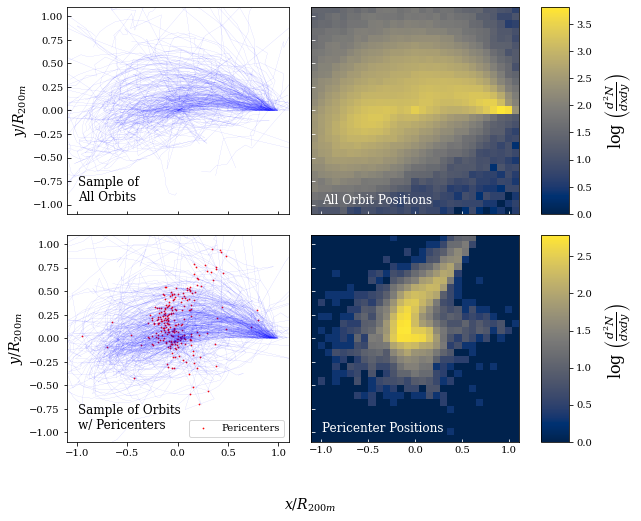

In [14]:
fig, axes = plt.subplots(2, 3, gridspec_kw = dict(width_ratios = [1, 1, 1/8], hspace = 0.1, wspace = 0.1), figsize = (9, 8))
cmap = plt.get_cmap('cividis')

mn, mx = plot_orb_hist(axes[0,1], has_peri, cmap, text = False)
norm = plt.Normalize(vmin=mn, vmax=mx)

scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable = scalar_mappable, cax = axes[0, 2])

mn, mx = peri_hist(axes[1,1], has_peri, cmap)

norm = plt.Normalize(vmin=mn, vmax=mx)

scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.colorbar(mappable = scalar_mappable, cax = axes[1, 2])

# alive_snap_count = np.sum(alive, axis = 1)
# sc_mask = alive_snap_count > 30
# long = np.where(sc_mask)[0]
plot_orb(axes[0,0], np.arange(ntcrs))
plot_orb_peri(axes[1, 0], np.where(has_peri)[0])
fig.text(1, 0.3, 'log $\\left( \\frac{d^2N}{dx dy} \\right)$', rotation = 'vertical', 
         fontsize = 16, ha = 'right', va = 'center')
fig.text(1, 0.7, 'log $\\left( \\frac{d^2N}{dx dy} \\right)$', rotation = 'vertical', 
         fontsize = 16, ha = 'right', va = 'center')

axes[0,0].tick_params(direction = 'in', which = 'both', labelbottom = False)
axes[0, 1].tick_params(direction = 'in', which = 'both')
axes[0,1].tick_params(direction = 'in', color = 'white', which = 'both', labelbottom = False, labelleft = False)
axes[1,1].tick_params(direction = 'in', color = 'white', which = 'both', labelleft = False)

axes[0,1].text(0.05, 0.05, 'All Orbit Positions', color = 'white', transform = axes[0,1].transAxes, fontsize = 12)
axes[1, 1].text(0.05, 0.05, 'Pericenter Positions', color = 'white', transform = axes[1, 1].transAxes, fontsize = 12)
fig.text(0.5, 0, '$x / R_{200m}$', fontsize = 14, ha = 'center', va = 'bottom')
axes[0,0].set_ylabel('$y / R_{200m}$', fontsize = 14)
axes[1,0].set_ylabel('$y / R_{200m}$', fontsize = 14)
fig.savefig(SAVE + 'orbit_hists_lines.png', dpi = 150)

(-1.0, 1.0)

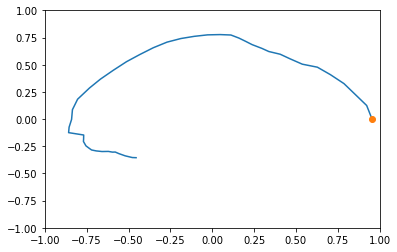

In [8]:
TOI = 24215
x, y = xy(TOI)
plt.plot(x, y)
plt.plot(x[0], y[0], marker = 'o')
plt.ylim(-1, 1)
plt.xlim(-1, 1)

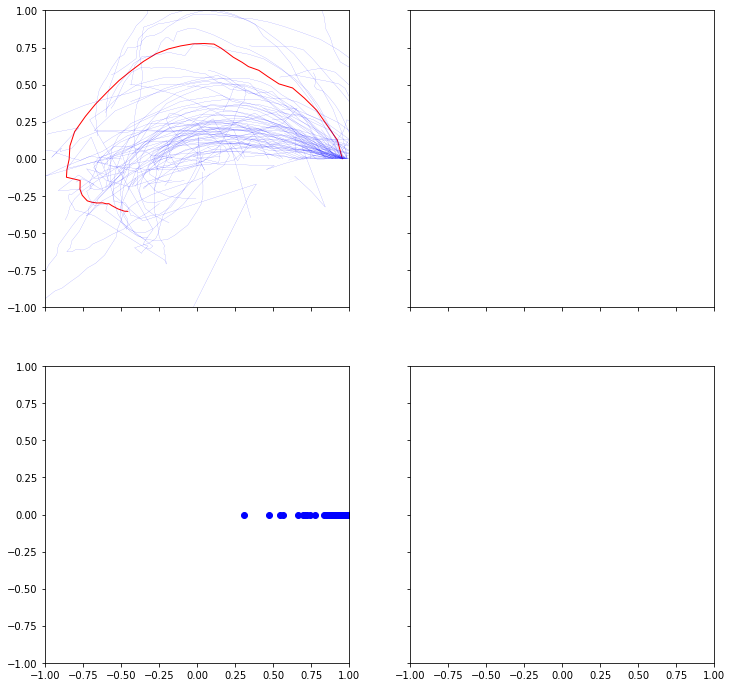

In [25]:
# make plot for all tracers of one halo
fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 12))
plt.ylim(-1, 1)
plt.xlim(-1, 1)
HOI = 17929

ftcr = hdata['sho_tjy_first'][HOI]
ltcr = ftcr + hdata['sho_tjy_n'][HOI]
tcr_slc = slice(ftcr, ltcr)
tcr_mask = np.zeros(len(tjy), dtype = bool)
tcr_mask[tcr_slc] = True

ppos = proj_pos.copy()

for i in range(ftcr, ltcr):
    x, y = xy(i)
    if i == TOI:
        ax[0, 0].plot(x, y, color = 'red', linewidth = 1)
        ax[1, 0].plot(x[0], y[0], color = 'red', marker = 'o')
    else:
        ax[0, 0].plot(x, y, color = 'blue', linewidth = 0.1)
        ax[1, 0].plot(x[0], y[0], color = 'blue', marker = 'o')

2746 0.10172630955027043


Text(0.5, 0, '$y/R_{200m}$')

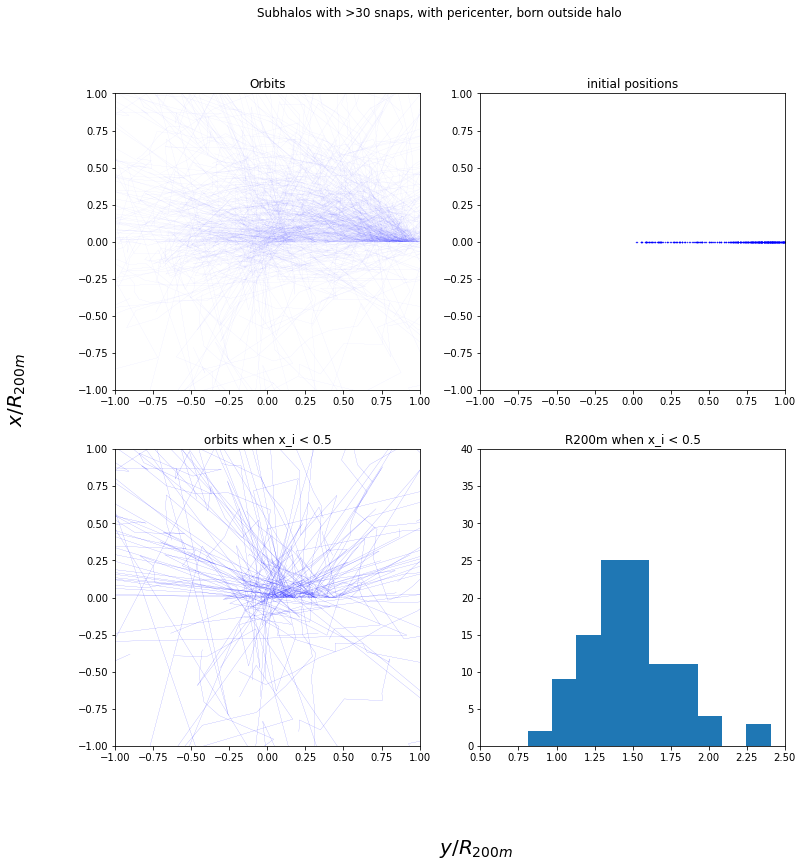

In [28]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

# subset of subhalos with a pericenter
has_pericenter = oct['n_pericenter'] > 0

# subhalos that persist for a significant period of time
alive_snap_count = np.sum(alive, axis = 1)
sc_mask = alive_snap_count > 30

# not born in halo
# ex_situ = ifl['born_in_halo'] > 0.5

mask = has_pericenter & sc_mask
ppos = proj_pos.copy()[mask]
print(np.sum(mask), np.sum(mask)/proj_pos.shape[0])

# select some random ones
rng_idxs = np.random.choice(ppos.shape[0], size = 500, replace = False)
# rng_idxs = np.arange(ppos.shape[0])
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.suptitle('Subhalos with >30 snaps, with pericenter')
ax[0, 0].set_title('Orbits')
ax[0, 1].set_title('initial positions')

ax[1, 0].set_title('orbits when x_i < 0.5')
ax[1, 1].set_title('R200m when x_i < 0.5')
radii = []
for a in [ax[0,0], ax[1, 0], ax[0, 1]]:
    a.set_ylim(-1, 1)
    a.set_xlim(-1, 1)
for i in range(len(rng_idxs)):
    x, y = xy(rng_idxs[i])
    ax[0, 0].plot(x, y, color = 'blue', linewidth = 0.02)
    ax[0, 1].plot(x[0], y[0], color = 'blue', marker = 'o', markersize = 0.4)
    
    if x[0] < 0.5:
        ax[1, 0].plot(x, y, color = 'blue', linewidth = 0.1)
        ihrad = hrad[rng_idxs[i], alive[rng_idxs[i]]]
        radii.append(ihrad[0])
ax[1,1].hist(np.log10(radii))
ax[1,1].set_xlim(0.5, 2.5)
ax[1,1].set_ylim(0, 40)
ax[1,1].set_xlabel('R_{200m} (cMpc/h)')
fig.text(0, 0.5, '$x/R_{200m}$', rotation = 'vertical', fontsize = 20)
fig.text(0.5, 0, '$y/R_{200m}$', fontsize = 20)

This plot shows the results of projecting orbits into

/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_18269/395703148.py:11: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(hist)


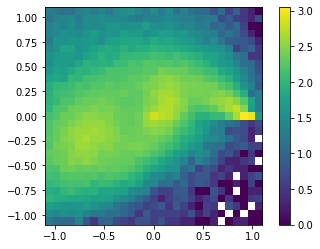

In [24]:
alive_sub = alive[mask,:]
hrad_sub = hrad[mask]
x = np.ravel(ppos[alive_sub, 0] / hrad_sub[alive_sub])
y = np.ravel(ppos[alive_sub, 1] / hrad_sub[alive_sub])

# bins = np.geomspace(0.1, 1.1, 10)
# bins = np.concatenate((bins[::-1]*-1, bins))
bins = np.linspace(-1.1, 1.1, 30)
hist, xedges, yedges = np.histogram2d(x, y, bins = [bins, bins])

data = np.log10(hist)
plt.imshow(np.flipud(np.rot90(data)), origin = 'lower', extent = (-1.1, 1.1, -1.1, 1.1))
plt.colorbar()
